### acinet analysis



In [1]:
import sys,os,subprocess,glob,shutil
%matplotlib inline
import pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Bio import Entrez
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO
from Bio import Phylo, AlignIO
#from epitopepredict import sequtils
from tools import *
pd.set_option('display.width', 130)
pd.set_option('display.max_colwidth', 120)
Entrez.email = 'A.N.Other@example.com'
from matplotlib.colors import ListedColormap, LogNorm
import matplotlib.patches as mpatches
from IPython.display import display, HTML
clrs = ["#007acc", "#2ecc71", "#e74c3c"]
my_cmap = ListedColormap(sns.color_palette(clrs).as_hex())
plt.rcParams["figure.dpi"] = 120
sns.set_style("white", {'font_scale':1.2})
from importlib import reload

In [2]:
info = pd.read_csv('isolates.csv')
names = info.id
isolates = info[info.stage!='reference'].id
acinet = ['RF14B','RF15A','RF15B']#,'909D3A']
refs = ['ecoli_k12','ecoli_IAI39','ecoli_O104_str.2011C-3493','ecoli_UMN026','ecoli_O157_str.Sakai']
acinrefs=['Acin_lwof_NCTC5866','Acin_lwof_ZS207', 'Acin_lwof_NIPH_715', 'Acin_lwof_NIPH478',
          'Acin_johnsonii_XBB1','Acin_lwof_CIP_64_10','Acin_lwof_F78','Acin_lwof_WJ10621','Acin_schi_CIP107287',
          'Acin_schi_str_ACE','Acin_sp_ACNIH1','Acin_sp_LoGeW2-3'] #'Acin_baum_ASM74664','Acin_pittii_PHEA-2'
ecoli = ['RF1A', 'RF2A', 'RF2B', 'RF2C', 'RF5A', 'RF6A1', 'RF6A2', 'RF6B', 'RF6C', 'RF7A', 
         'RF8A', 'RF8B', 'RF9', 'RF11', 'RF12A', 'RF14A', 'RF16A']
pen = ['RF14B', 'RF15A', 'RF15B', 'RF14A','RF16A', 'ecoli_k12', 'Acin_lwof_NCTC5866']
pig = ecoli[:-8] + ['ecoli_k12'] + acinet + ['Acin_lwof_NCTC5866']
dog=['9805','9808']


In [ ]:
import shutil
fl=glob.glob('annot/*')
for f in acinet+acinrefs:
    #print f
    fn=glob.glob('annot/%s/*.gff' %f)[0]
    print fn
    #shutil.copy(fn,'compare_acinet/acinet_gff')

In [5]:
s=' '.join(['scaffolds/%s.fa' %i for i in acinet])
#print s
cmd = 'quast.py %s -R genomes/Acin_sp_ACNIH1.fa -o compare_acinet/quast_results -t 4' %s
print (cmd)

quast.py scaffolds_trimmed/RF14B.fa scaffolds_trimmed/RF15A.fa scaffolds_trimmed/RF15B.fa -R genomes/Acin_sp_ACNIH1.fa -o compare_acinet/quast_results -t 4


In [47]:
cmd = 'roary -f compare_acinet/roary -e -n -v -z -i 80 -cd 70 -p 6 compare_acinet/acinet_gff_scaff/*.gff'
print cmd

roary -f compare_acinet/roary -e -n -v -z -i 80 -cd 70 -p 6 compare_acinet/acinet_gff_scaff/*.gff


### nucmer genome alignments

In [ ]:
alignrefs = ['Acin_lwof_NCTC5866','Acin_lwof_ZS207', 'Acin_schi_CIP107287','Acin_sp_ACNIH1','Acin_rudis_CIP110305','Acin_sp_TTH0-4']

for n in ['RF14B']:
    for ref in alignrefs:        
        cmd='nucmer --maxgap=500 --mincluster=100 --coords -p nucmer genomes/{r}.fa scaffolds/{n}.fa'.format(r=ref,n=n)    
        print cmd  
        out = 'compare_acinet/{n}_{r}.coords'.format(r=ref,n=n)
        if not os.path.exists(out):
            subprocess.check_output(cmd,shell=True)
            shutil.move('nucmer.coords',out)
            #cmd = 'delta-filter -q -r nucmer.delta > compare_acinet/{n}_{r}.filter'.format(r=ref,n=n)
            #subprocess.check_output(cmd,shell=True)


In [ ]:
for ref in alignrefs:  
    print ref
    df = read_nucmer_coords('compare_acinet/RF14B_%s.coords' %ref)
    print len(df)
    #print df[:20]
    df.hist('IDENT',figsize=(4,2))
    plt.show()

In [ ]:
#get rpoB genes from genbank?
request = Entrez.esearch(db="nucleotide", term="rpoB AND Acinetobacter[porgn]", field="title", rettype='xml', retmax=150)
result = Entrez.read(request)
id_list = result['IdList']
print id_list
#recs = retrieve_sequences(id_list)
#print recs
#recs_to_fasta(recs, 'compare_acinet/rpoB_cds.fa')

In [64]:
import tools
reload(tools)
id_list = ['DQ207410']
#x = open('id_list.txt','r').readlines()
#id_list = [i.rstrip() for i in x]
#print id_list
#recs = tools.retrieve_sequences(id_list)
#tools.recs_to_fasta(recs, 'compare_acinet/rpoB-rpoC_spacer.fa')

df=tools.align_nucmer('compare_acinet/rpo_contigs.fa','compare_acinet/rpoB-rpoC_spacer.fa')
df=df.sort_values('IDENT',ascending=False)
print df
contseqs = SeqIO.to_dict(SeqIO.parse('scaffolds/RF14B.fa','fasta'))

nucmer --maxgap=500 --mincluster=100 --coords -p nucmer compare_acinet/rpo_contigs.fa compare_acinet/rpoB-rpoC_spacer.fa
Empty DataFrame
Columns: [S1, E1, S2, E2, LEN 1, LEN 2, IDENT, TAG1, TAG2]
Index: []


In [ ]:
spacers = list(SeqIO.parse('compare_acinet/rpoB-rpoC_spacer.fa','fasta'))
s = contseqs['NODE_78_length_13914_cov_55.7317']
#print len(s)-8600
frag = s[5314:5514].reverse_complement()
frag.id='RF14B'
spacers.append(frag)
aln = sequtils.clustal_alignment(seqs=spacers)
dm,tree=get_tree(aln)
draw_tree(tree)
#sequtils.show_alignment(aln)

In [ ]:
#get contig hit for rpoB
rposeqs = list(SeqIO.parse('compare_acinet/rpoB.fa','fasta'))

s = contseqs['NODE_78_length_13914_cov_55.7317']

lbls = {r.id: r.description for r in rposeqs}
#print lbls
frag = s[5514:9602].reverse_complement()
frag.id='RF14B'
rposeqs.append(frag)
#aln = sequtils.muscle_alignment(seqs=rposeqs)
aln = sequtils.clustal_alignment(seqs=rposeqs)
AlignIO.write(aln,'compare_acinet/rpoB.aln','fasta')
dm,tree=get_tree(aln)
draw_tree(tree, labels=lbls)


In [ ]:
#align reads to gene to get consensus...

files = glob.glob( 'data/RF14B*.gz')
a = 'rpoB'
tools.align_reads(files[0], files[1], 'compare_acinet/indexes/%s.fa' %a, 'compare_acinet/RF14B_%s_mapped.bam' %a)


In [ ]:
#bl=utils.local_blast('scaffolds/RF15A.fa','acineto_16S_silva', params='-e .1', ident=95)
bl=tools.local_blast('compare_acinet/16S_seqs.fasta','acineto_16S_silva', params='-e .1', ident=95)
bl=bl[bl.length>500]
s = Seq(bl.iloc[0].sequence)
bl = bl.sort_values('pident',ascending=False)
#bl.to_csv('compare_acinet/16S_blast.csv')
bl

### acinetobacter annotation

In [8]:
x=prokka_results('annot_scaff/',['RF14B'])

RF14B 2770


RF14B 2770
RF15A 2877
RF15B 2876
Acin_lwof_NCTC5866 3076
Acin_lwof_ZS207 3162
Acin_lwof_NIPH_715 3367
Acin_lwof_NIPH478 2101
Acin_johnsonii_XBB1 4070
Acin_lwof_CIP_64_10 3076
Acin_lwof_F78 2933
Acin_lwof_WJ10621 3144
Acin_schi_CIP107287 3256
Acin_schi_str_ACE 2897
Acin_sp_ACNIH1 3243
Acin_sp_LoGeW2-3 3083


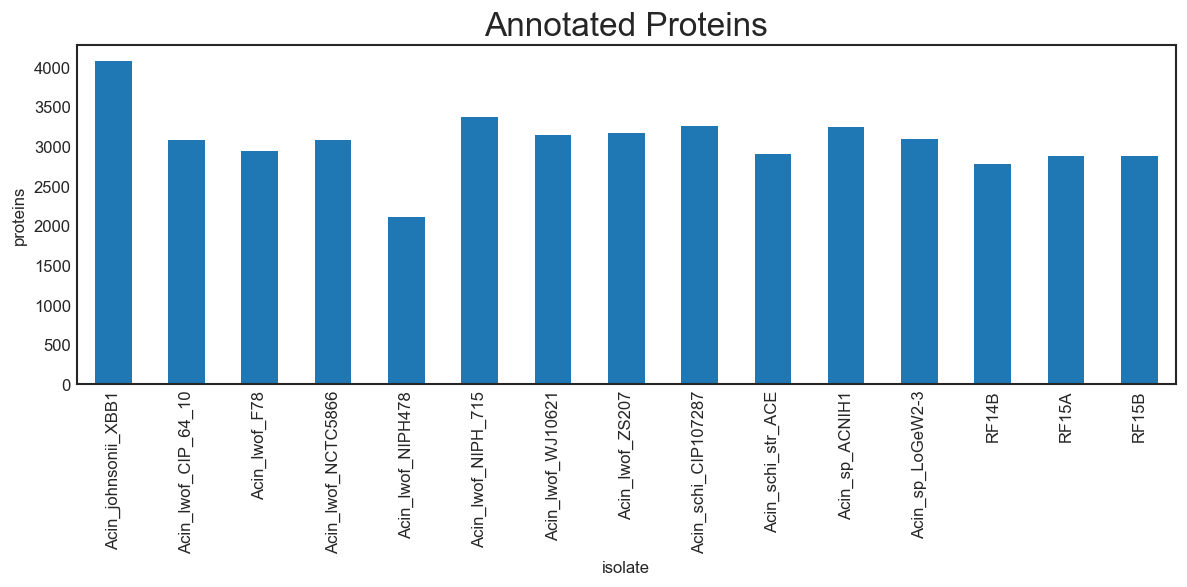

In [60]:
x=prokka_results('annot_scaff/',acinet+acinrefs)
plot_products(x)
plt.savefig('prokka_counts_acinet.png')
#print x
#log_heatmap(x[-100:])
plt.tight_layout()
#plt.savefig('prokka_heatmap_acin.png')

group                accessory  core
Acin_johnsonii_XBB1       2703  1236
Acin_lwof_CIP_64_10       1363  1618
Acin_lwof_F78             1222  1609
Acin_lwof_NCTC5866        1363  1618
Acin_lwof_NIPH478          884  1156
Acin_lwof_NIPH_715        1643  1611
Acin_lwof_WJ10621         1903  1132
Acin_lwof_ZS207           1457  1612
Acin_schi_CIP107287       1591  1568
Acin_schi_str_ACE         1207  1590
Acin_sp_ACNIH1            1503  1600
Acin_sp_LoGeW2-3          1421  1548
RF14B                     1118  1569
RF15A                     1200  1584
RF15B                     1191  1586


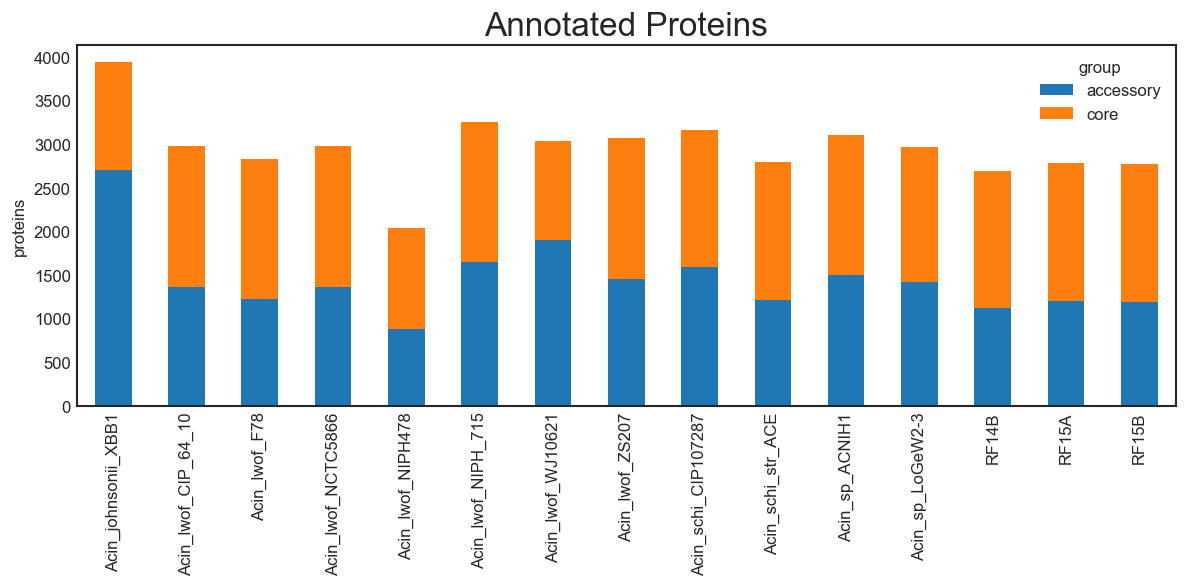

In [56]:
roary = pd.read_csv('compare_acinet/roary/gene_presence_absence.csv')
x = get_presence_absence(roary)
x.index=x.index.droplevel([0,2])

#core genes in x genomes
#x['core'] = x.sum(1)/x.count(1)>.7
x['group'] = np.where(x.sum(1)/x.count(1)>.7,'core','accessory')

#x['unique'] = (x[acinet].sum(1)==3) & (x[acinrefs].sum(1)==0)
#print x[:10]
print x.groupby(['group']).sum().T
x.groupby(['group']).sum().T.plot(kind='bar', stacked=True, figsize=(10,5))
plt.title('Annotated Proteins',fontsize=20)
plt.ylabel('proteins')
plt.tight_layout()
plt.savefig('compare_acinet/roary_counts.png')


In [ ]:
files = ['compare_acinet/acinet_gff_scaff/%s.gff' % n for n in acinet]
contig_report(files, 'compare_acinet/contig_report.html', key='ARO')

11270
other 3144
putative HTH-type transcriptional regulator                                                       29
Replication initiation protein                                                                    29
Fimbrial protein                                                                                  25
Colicin I receptor                                                                                20
Vitamin B12 transporter BtuB                                                                      20
putative diguanylate cyclase YcdT                                                                 18
Mobilization protein A                                                                            17
HTH-type transcriptional regulator DmlR                                                           16
Phytochrome-like protein cph2                                                                     14
putative signaling protein                                                

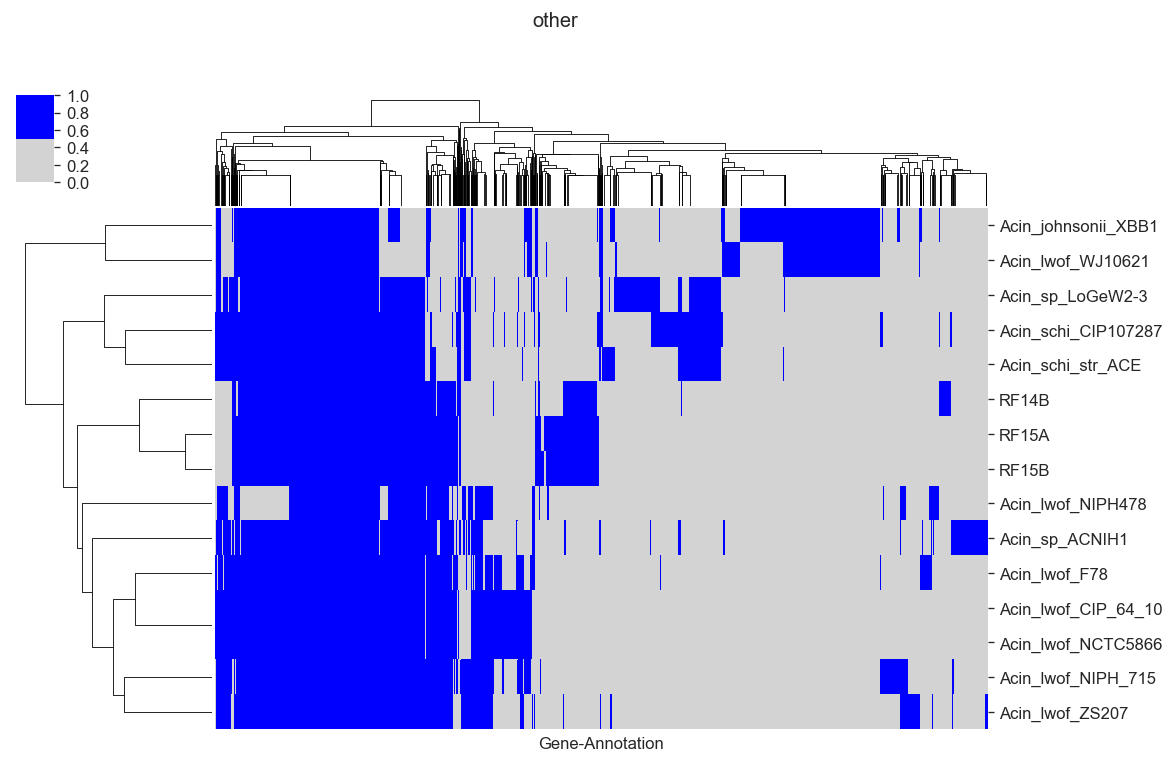

In [19]:
x = get_presence_absence(roary)
x = x[x.sum(1)>=1]
print (len(x))
#print x.sum(1)
#genes_clustermap(x.T)
#plt.savefig('compare_acinet/roary_acin_genes.png')

mycats = ['other']#,'IS','phage','integrase']
for n in mycats[:2]:    
    df = x.loc[(n)]    
    print (n, len(df))
    print (df.reset_index().Annotation.value_counts())
    genes_clustermap(df.T,title=n)

In [ ]:
#tree from blast result
btree=Phylo.parse('compare_acinet/blast_tree.nwk','newick').next()
draw_tree(btree)


### phlyogenetic trees using roary res

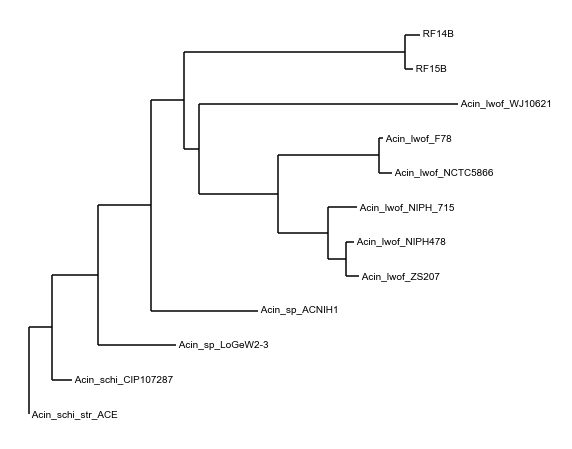

In [11]:
#['gltA','gyrB','gdhB','recA','cpn60','gpi','rpoD']
#seqs,lbls = get_roary_protein(acinet+acinrefs, 'dnaJ', 'compare_acinet/roary')
#aln=sequtils.muscle_alignment(seqs=seqs)
aln = get_roary_gene('rpoB')
#sequtils.show_alignment(aln)
#dm,tree=get_tree(aln)
#f,tr=draw_tree(tree,root='Acin_lwof_NCTC5866')
AlignIO.write(aln,'temp.aln','fasta')
#mtree = ml_tree(aln,'temp')
Phylo.write(mtree, 'compare_acinet/rpoB_tree.xml', 'phyloxml')
f,tr=draw_tree(mtree,root='Acin_schi_str_ACE')
f.savefig('compare_acinet/tree_rpoB.png')


core


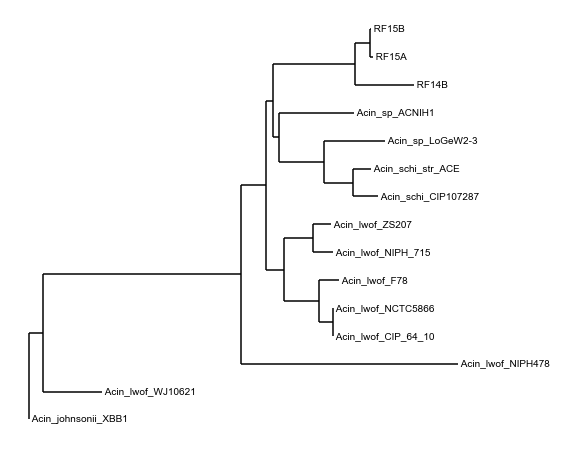

In [3]:
acinseqs = AlignIO.read('compare_acinet/roary/core_gene_alignment.aln','fasta')
aln=AlignIO.MultipleSeqAlignment(acinseqs)
#dm3,tree3=get_tree(aln)
#mtree = ml_tree(aln,'temp')

#aln4 = AlignIO.read('compare_acinet/roary/accessory_binary_genes.fa','fasta')
#dm4,tree4=get_tree(aln4)
#Phylo.write([tree3,tree4], 'compare_acinet/roary_trees.xml', 'phyloxml')

r=Phylo.parse('compare_acinet/roary_trees.xml', 'phyloxml')
tree3=r.__next__()

print ('core')
f,tr=draw_tree(tree3,root='Acin_johnsonii_XBB1', title='core genes')#, clear=False)
f.savefig('compare_acinet/tree_acin_core.png')
#Phylo.write(tr, 'compare_acinet/roary_trees_rooted.xml', 'phyloxml')


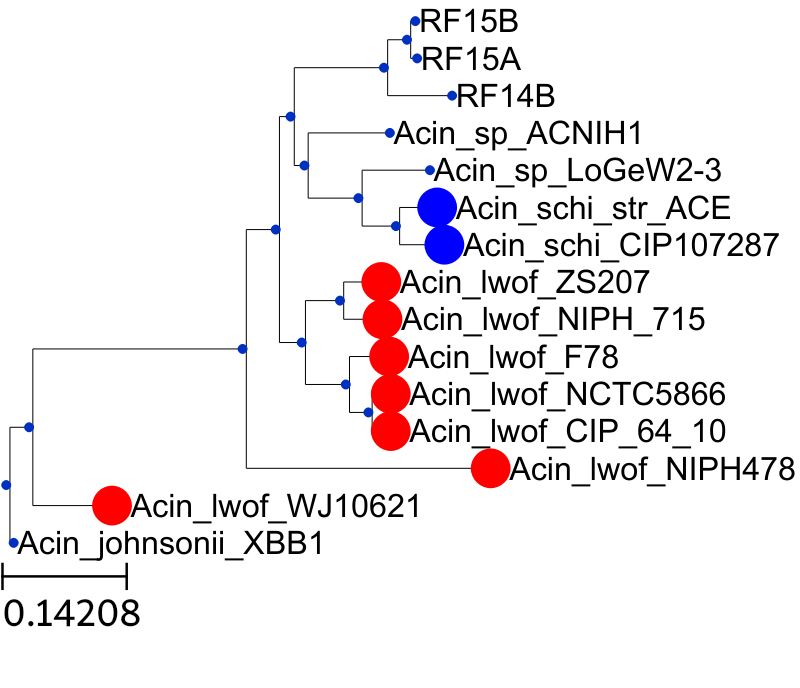

In [4]:
import tools
reload(tools)
t=get_ete_tree('compare_acinet/roary_trees_rooted.xml')
#print t
#ancestor = t.get_common_ancestor("Acin_johnsonii_XBB1","Acin_lwof_NIPH478")
#print ancestor
#t.set_outgroup(ancestor)

#print t
lbls={}
for a in acinrefs+acinet:
    lbls[a] = a.replace('_',' ').replace('lwof','lwoffii').replace('Acin','A.')

colors={}
for i in lbls:
    if 'lwoffi' in lbls[i]:
        colors[i] = 'red'
    elif 'sch' in lbls[i]:
        colors[i] = 'blue'
    
def render(ts):     
    display(t.render("%%inline",w=800))#,treestyle=ts)

#ete_labels(t, lbls, position='branch-right')
tools.ete_colors(t, colors)
ts=tools.ete_draw(t,outfile='compare_acinet/tree_acin_core.png')
render(ts)


### use selected housekeeping genes from roary to make an alignment and ML tree

argS 15
gltA 15
rplJ 15
recA 15
groL 15
recN 15
rpoB 15


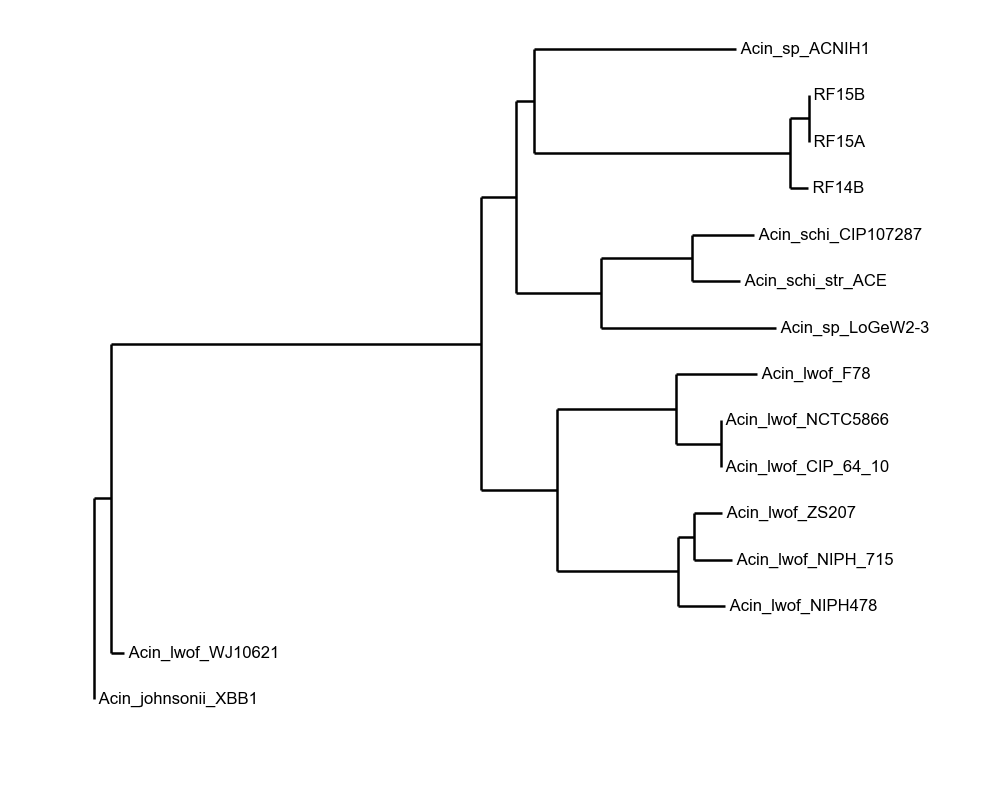

In [16]:
from Bio.Phylo.Consensus import *
from Bio.Phylo.Applications import PhymlCommandline

def get_concatenated_genes(genes, path='roary', omit=[]):
    """get subsets of genes from roary and concatenate"""
    seqrecs={}
    for g in genes:        
        aln = get_roary_gene(g, path)        
        if aln is None:
            continue
        for seq in aln:
            n = seq.id
            if n not in seqrecs:
                seqrecs[n] = ''
            seqrecs[n]+=seq.seq
        print g, len(aln)
    seqs=[]      
    for n in seqrecs:
        if n in omit: continue
        s=seqrecs[n]    
        seqs.append(SeqRecord(s,id=n))
        #print SeqRecord(s,id=n)
    return seqs

#see http://ijs.microbiologyresearch.org/content/journal/ijsem/10.1099/ijs.0.02713-0#tab2 
#http://ijs.microbiologyresearch.org/content/journal/ijsem/10.1099/ijs.0.016949-0#tab2

hkgenes = ['argS','gltA','rplJ','recA','groL','recN','rpoB']
l = info.set_index('id')['stage'].to_dict()

seqs = get_concatenated_genes(hkgenes, 'compare_acinet/roary')
haln = muscle_alignment(seqs=seqs)
haln = AlignIO.MultipleSeqAlignment(haln)
AlignIO.write(haln,'compare_acinet/hkgenes.aln','fasta')
dm,tree=get_tree(haln)
#tree = ml_tree(haln, 'compare_acinet/hkgenes')
Phylo.write(tree, 'compare_acinet/hkgenes_tree.xml', 'phyloxml')
#f,tr=draw_tree(tree,root='Acin_johnsonii_XBB1',title='housekeeping genes')
#f.savefig('compare_acinet/tree_hk_genes.png')


In [ ]:
t=get_ete_tree('compare_acinet/hkgenes_tree.xml')
ts=ete_draw(t,outfile='compare_acinet/tree_acin_core.png')

### ANI from jspeciesws

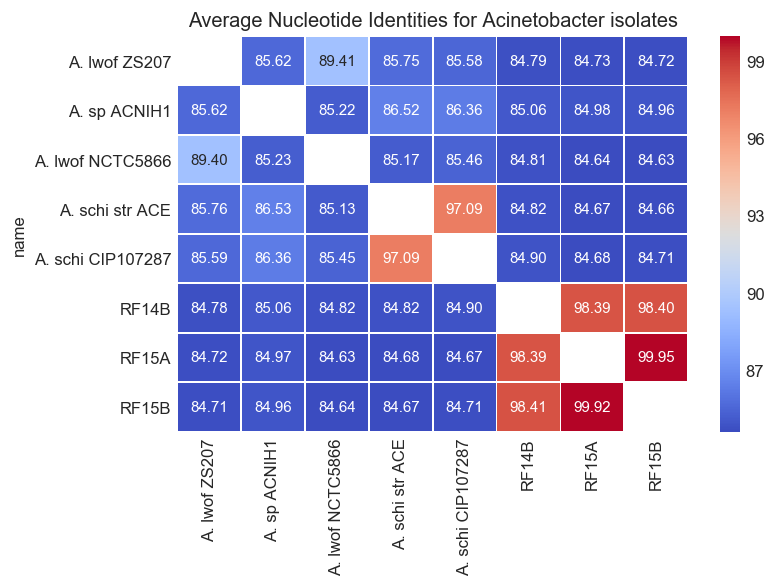

In [53]:
ani=pd.read_csv('compare_acinet/ANIm.csv')
ani = ani.set_index('name')
f, ax = plt.subplots(figsize=(7, 5))
hm=sns.heatmap(ani,ax=ax,annot=True,cmap='coolwarm',fmt=".2f",linewidths=.5,annot_kws={'fontsize':9})
ax.set_title('Average Nucleotide Identities for Acinetobacter isolates')
plt.tight_layout()
plt.savefig('compare_acinet/ANI_acin.png',dpi=150)

### align to ref

In [ ]:
#print acinrefs
for a in ['Acin_lwof_ZS207','Acin_schi_CIP107287','Acin_sp_ACNIH1','Acin_schi_str_ACE']:
    print a
    path='data'        
    files = glob.glob( 'data/'+name+'*.gz')    
    tools.align_ref(files[0], files[1], 'genomes/indexes/%s.fa' %a, 'compare_acinet/RF14B_%s_mapped.bam' %a)
    tools.align_info('compare_acinet/RF14B_%s_mapped.bam' %a)

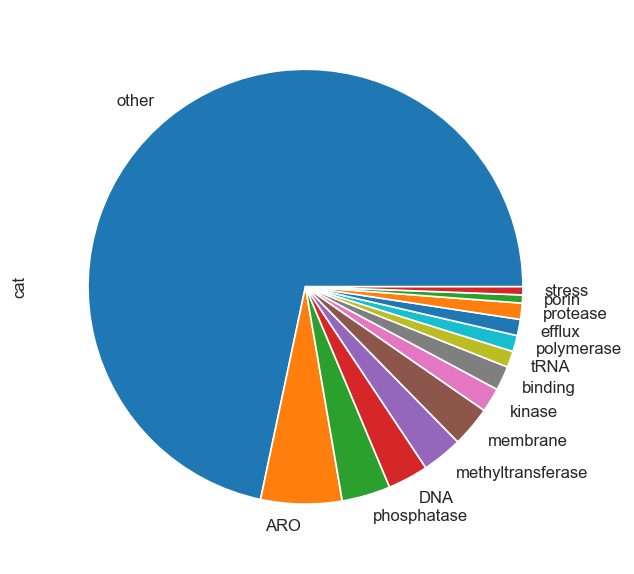

In [21]:
roary = pd.read_csv('compare_acinet/roary/gene_presence_absence.csv')
x = get_presence_absence(roary)
x = x.sort_index()
#print (x[:4])
cats = x.reset_index().groupby('cat').sum().T
#print cats

#get genes unique in isolates - novel proteins?
filt = x[(x[acinet].sum(1)==3) & (x[acinrefs].sum(1)==0)].reset_index()
#print filt
c = filt.cat.value_counts()
#print (c)
print (c.sum())
c[1:].plot(kind='pie',figsize=(6,6))

## individual sequences for proteins of interest

* are any proteins novel?
* are they mutated in novel locations
    1. blast to local nr and do seq alignments
    2. align with only roary genomes - done?
* structural analysis of any proteins possible? ssbio? itasser? modb?
* unknown proteins?


In [22]:
x = filt[filt.cat=='ARO']

for i,r in list(x.iterrows())[:15]:
    print()
    print (r.Annotation)
    g=r.Gene
    seqs,lbls = get_roary_protein(g, 'compare_acinet/roary')
    aln = muscle_alignment(seqs=seqs)   
    #show_alignment(aln)
    
    for s in seqs:
        print (lbls[s.id], s.id, s.seq)
    #aln=get_roary_gene(g)
    


VanS: trasncriptional regulator of van glycopeptide resistance genes [ARO:3000071]
RF14B DHDDBANL_00084 MRSYSLKWRLVISLLLVFLCLWSIVFAWLYIDLQKRLQETLDQRLSASAHMVARLIQQLPVQAIHHELIQQPNKSADAENLIACEVSLFSSDISVGQQVLAKTRGAPANLSQQPSGFSTWQSGGIEWRSYVLRKGDIQIVAAERMFLRESLLQQILRSVLIPLMLSLLICTILIVLIIRREFKSLDDIAQHLSQKNLTLTAATQYLTDLDPRHIPHEVQPFVDNSTQLIQKLHHSLENEKVFTAYAAHELRSPLTAIKTHVQLAQLMAQHEASPKLQQNLQQADTSIRRYAELLEQLLTLSSLEHNKIEELGSTEVASVLRQVIQDLQPAYPALQSSLNIDWESLTSIQLPDFALYTVLKNLMENAALHAHADVISISMQDKSMIFQDNGSILDQTEMENLGQRFWRKSSQQPGHGLGLSLVKTLLRKYHYHLEFQAAQPHGLMVKLSPLSD
RF15A APBANILF_00488 MRSYSLKWRLVISLLLVFLCLWSIVFAWLYIDLQKRLQETLDQRLSASAHMVARLIQQLPIQAIHHELIQQPNKSADAENLIACEVSLFSSDISVGQQVLAKTRGAPANLSQQPSGFSTWQSGGIEWRSYVLRKGDIQIVAAERMFLRESLLQQILRSVLIPLMLSLLICTILIVLIIRREFKSLDDIAQHLSQKNLTLTAATQYLTDLDPRHIPHEVQPFVDNSTQLIQKLHHSLENEKVFTAYAAHELRSPLTAIKTHVQLAQLMAQHEASPKLQQNLQQADTSIRRYAELLEQLLTLSSLEHNKIEELGSTEVASVLRQVIQDLQPAYPALQTSLNIDWESLTSIQLPDFALYTVLKNLMENAALHAHADVISIYMQDKSIIFQDNGSILDQTEMENLGQRFWRKSSQQPGHGLGLSL

/home/damien/ana_isolates/tools.py:370: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  lbls = r.loc[samples].to_dict()


RF14B DHDDBANL_00619 MADPIRSYSLTQRLSIILLAITTSVWLGSLGSIYWGMQNTANNIFDKSLAETAHALLSTTLSTLDGKVPQHTVIEKAKGEHYDQIVFQIWHRDGQLIYRSIGVETQPFVQQDNFGWIKLNNNTYRSYSVWDSTHTIQVQIAQVWTIRKDIQQDMLLFLILVSIIFLPLLLWLIICTIRRHLLAVYSISQNLEKQSIEHLNPIKPVVPKEIEPLVSSLNTLLSEIAESMQREKRFTSNAAHELRTPLAAIRLHAQVLQNARSNEESKEAAQDIITGVDKASRMITQLLTLARLEPNATQNKSNIDLVDIVKGTVEMMGIQFRKAGVDLQLHLTSVCVWGQSDQLEIMLRNILENAILYRSSIHKPIIKVSCGSIGNGSFIQVEDNGIGLDEAQIPFIFQRFYRINQASSVVGSGLGLSIVKQIIDSHLGKITLQRANAVGGLIVRIEFFKKLNIY
RF15A APBANILF_01239 MADPIRSYSLTQRLSIILLAITTSVWLGSLGSIYWGMQNTANNIFDKSLAETAHALLSTTLSTLDGKVPQHTVIEKAKGEHYDQIVFQIWHRDGQLIYRSIGVETQPFVQQDNFGWIKLNNNTYRSYSVWDSTHTIQVQIAQVWTIRKDIQQDMLLFLILVSIIFLPLLLWLIICTIRRHLLAVYSISQNLEKQSIEHLNPIKPVVPKEIEPLVSSLNTLLSEIAESMQREKRFTSNAAHELRTPLAAIRLHAQVLQNARSNEESKEAAQDIITGVDKASRMITQLLTLARLEPNATQNKSNIDLVDIVKGTVEMMGIQFRKAGVDLQLHLTSVCVWGQSDQLEIMLRNILENAILYRSSIHKPIIKVSCGSIGNGSFIQVEDNGIGLDEAQIPFIFQRFYRINQASSVVGSGLGLSIVKQIIDSHLGKITLQRANAVGGLIVRIEFFKKLNIY
RF15B KPHOGIJM_01785 MADPIRSYSLTQRLSIILLAITTSVWL

In [ ]:
## sequence conservation of our proteins in interesting categories.